In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

In [2]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

False


In [3]:
data_dir = "data/flower-photos/flower_photos/"
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = []
for class_name in os.listdir(train_dir):
    classes.append(class_name)
print(classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [4]:
# DAta transformaion

data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)


In [5]:
# Dataloaders
BATCH_SIZE = 20
NUM_WORKERS = 0

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


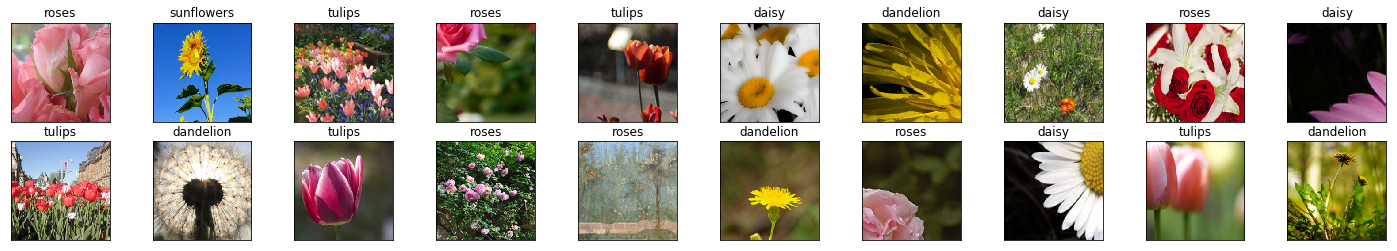

In [6]:
# Simple viz
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Convert torch to numpy
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [7]:
# Create pretrained model
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\matthew.millar/.cache\torch\checkpoints\vgg16-397923af.pth


In [9]:
# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [11]:
# Freeze layer for training stop saving over feature layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [13]:
n_inputs = vgg16.classifier[6].in_features # Get the last layer input features
# Cahnge output to 5 classes (Flowers)
last_layer = nn.Linear(n_inputs, len(classes))
# Create a new layer and replace the last layer in vgg16 to it
vgg16.classifier[6] = last_layer

if train_on_gpu:
    vgg16.cuda()
    
# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

5


In [14]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [16]:
EPOCHS = 2

for epoch in range(1, EPOCHS + 1):
    train_loss = 0.0
    
    for batch_i, (data, label) in enumerate(train_loader):
        if train_on_gpu:
            data, label = data.cuda(), label.cuda()
        
        optimizer.zero_grad()
        
        output = vgg16(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %(epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5824709773063659
Epoch 1, Batch 40 loss: 1.3733247399330140
Epoch 1, Batch 60 loss: 1.2590714156627656
Epoch 1, Batch 80 loss: 1.1506267368793488
Epoch 1, Batch 100 loss: 1.0533181250095367
Epoch 1, Batch 120 loss: 0.9981916606426239
Epoch 1, Batch 140 loss: 0.8979669123888016
Epoch 2, Batch 20 loss: 0.8812158346176148
Epoch 2, Batch 40 loss: 0.8899914354085923
Epoch 2, Batch 60 loss: 0.8165115505456925
Epoch 2, Batch 80 loss: 0.8028712332248688
Epoch 2, Batch 100 loss: 0.7843915164470673
Epoch 2, Batch 120 loss: 0.7466041058301925
Epoch 2, Batch 140 loss: 0.6875901088118553


In [18]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval()

for data, label in test_loader:
    if train_on_gpu:
        data, label = data.cuda(), label.cuda()
    output = vgg16(data)
    loss = criterion(output, label)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(BATCH_SIZE):
        lab = label.data[i]
        class_correct[lab] += correct[i].item()
        class_total[lab] +=1
    
    # calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.719717

Test Accuracy of daisy: 75% (69/92)
Test Accuracy of dandelion: 96% (127/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 75% (76/101)
Test Accuracy of tulips: 69% (86/124)

Test Accuracy (Overall): 77% (419/540)


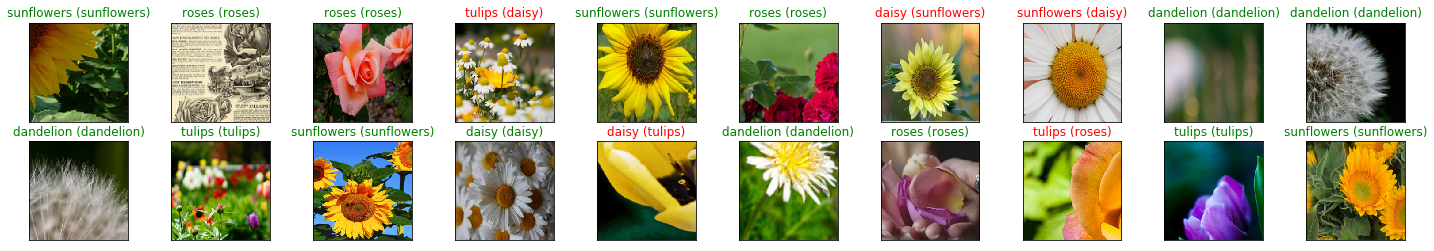

In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))